Here we implement the RNN model: https://github.com/0aqz0/SLR/blob/master/models/ConvLSTM.py

## 1 Load Data

In [113]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc
from torch.utils.data import Dataset, DataLoader, Subset
import glob
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

In [114]:
upperlimit = 500
cutoff = 406
train = pd.read_pickle("data/noor2/CorpusNGT/train_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
test  = pd.read_pickle("data/noor2/CorpusNGT/test_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
val   = pd.read_pickle("data/noor2/CorpusNGT/validate_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))

In [115]:
tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

20
7477


In [4]:
catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

7477 7477
936 936
934 934


In [5]:
print(labels_dict.keys())

dict_keys(['1-A', 'AL', 'BINNEN', 'GEBAREN-A', 'GEHANDICAPT-A', 'GOED-A', 'HEE', 'HOREN-A', 'JA-A', 'KIJKEN-A', 'KUNNEN-A', 'LAAT-MAAR', 'MAAR', 'PO', 'POPT', 'PT', 'PV', 'SAMEN-A', 'ZELF', 'ZELFDE-A'])


### 2 Datasets and Transforms

In [6]:
np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [7]:
# Choose some of the data transform values

timesteps = 8

data_aug = False
batch_size = 32

h, w =224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# h, w = 270, 270
# mean = [0.43216, 0.394666, 0.37645]
# std = [0.22803, 0.22145, 0.216989]

In [8]:
# class VideoDataset(Dataset):
#     def __init__(self, ids, labels, transform):
#         self.transform = transform
#         self.ids = ids
#         self.labels = labels
#     def __len__(self):
#         return len(self.ids)
#     def __getitem__(self, idx):
#         path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
#         path2imgs = path2imgs[:timesteps]
#         label = labels_dict[self.labels[idx]]
#         frames = []
#         for p2i in path2imgs:
#             frame = Image.open(p2i)
#             frames.append(frame)

#         seed = np.random.randint(1e9)
#         frames_tr = []
#         for frame in frames:
#             random.seed(seed)
#             np.random.seed(seed)
#             frame = self.transform(frame)
#             frames_tr.append(frame)
#         if len(frames_tr)>0:
#             frames_tr = torch.stack(frames_tr)
#         return frames_tr, label


class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.file_paths = []  # List to store file paths for each sample

        # Precompute the file paths
        for video_id in self.ids:
            path2imgs = glob.glob(video_id + "/*.jpg")
            path2imgs = path2imgs[:timesteps]
            self.file_paths.append(path2imgs)  # Store the list of file paths for each video

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Get the file paths for this sample (video)
        path2imgs = self.file_paths[idx]
        label = labels_dict[self.labels[idx]]

        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        # Apply transformations to frames
        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        
        if len(frames_tr) > 0:
            frames_tr = torch.stack(frames_tr)

        return frames_tr, label


In [9]:
# define helper functions

def transform_frames(frames):
    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

        # imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor


def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [10]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])


train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

print(train_ds)

7477


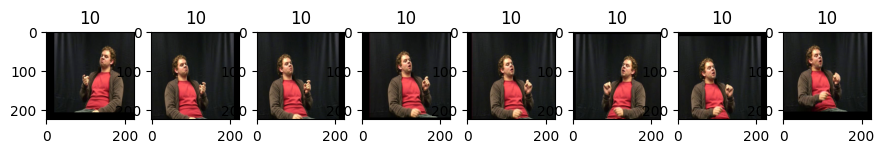

In [11]:
%matplotlib inline

# inspect
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

## For image condition, not keypoints
plt.figure(figsize=(12,12))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [12]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))
val_ds = VideoDataset(ids= val_ids, labels= val_labels, transform= test_transformer)
print(len(val_ds))

936
934


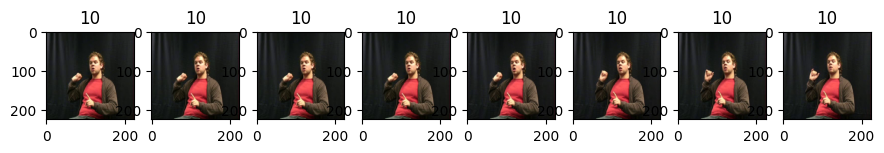

In [13]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)
plt.figure(figsize=(12,12))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

### 3 Dataloader

In [14]:
def collate_fn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)

In [15]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 3, 8, 224, 224]) torch.Size([32])


### 4 Define Model

In [16]:
## Here a we implement the ResNet network from the GitHub Repo

import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import r3d_18  # Import pre-trained 3D ResNet-18
from torch.hub import load_state_dict_from_url
import torchfile
from collections import OrderedDict

"""
Implementation of 3D ResNet
"""

class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet3D, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, 3, 8, 224, 224)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model_urls = {
    'resnet18': 'https://www.jianguoyun.com/c/dl-file/resnet-18-kinetics.pth?dt=q67aev&kv=YXF6QHpqdS5lZHUuY24&sd=a54cr&ud=B8Sbfz0nRv1pG8YNAbo0KiCnzvJHDsLYQsWjtT4b1j8&vr=1',
}

def resnet3d18(num_classes, pretrained=False):
    model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes)
    if pretrained:
        checkpoint = load_state_dict_from_url(model_urls['resnet18'],
            progress=True)
        state_dict = checkpoint['state_dict']

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove 'module.'
            new_state_dict[name]=v
        model.load_my_state_dict(new_state_dict)
    return model

import torch
from collections import OrderedDict

def load_pth_model(model, pth_path):
    checkpoint = torch.load(pth_path, map_location=torch.device('cpu'))  # Load on CPU to avoid GPU mismatch
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k  # Remove 'module.' prefix if present
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict, strict=False)  # strict=False to allow size mismatches in final layer
    return model

In [17]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def calculate_metrics(preds, labels, num_classes):
    """
    Calculate overall and per-class precision and recall.
    Precision: TP / (TP + FP)
    Recall: TP / (TP + FN)
    """
    per_class_correct = torch.zeros(num_classes, device=preds.device)  # True Positives (TP)
    per_class_predicted = torch.zeros(num_classes, device=preds.device)  # TP + FP
    per_class_actual = torch.zeros(num_classes, device=preds.device)  # TP + FN

    for cls in range(num_classes):
        tp = ((preds == cls) & (labels == cls)).sum().float()  # True Positives
        total_pred = (preds == cls).sum().float()  # TP + FP
        total_actual = (labels == cls).sum().float()  # TP + FN

        per_class_correct[cls] = tp
        per_class_predicted[cls] = total_pred
        per_class_actual[cls] = total_actual

    # Compute per-class precision and recall
    per_class_precision = per_class_correct / (per_class_predicted + 1e-8)  # TP / (TP + FP)
    per_class_recall = per_class_correct / (per_class_actual + 1e-8)  # TP / (TP + FN)

    # Overall metrics
    overall_precision = per_class_correct.sum() / (per_class_predicted.sum() + 1e-8)
    overall_recall = per_class_correct.sum() / (per_class_actual.sum() + 1e-8)

    return overall_precision.item(), per_class_precision.cpu().numpy(), overall_recall.item(), per_class_recall.cpu().numpy()



def train_model_with_metrics(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs, num_classes, path2weights, lr_scheduler=None
):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_precision_per_class, val_precision_per_class = [], []
    train_recall_per_class, val_recall_per_class = [], []

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            all_preds, all_labels = [], []

            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

            # Convert predictions and labels to tensors for metric calculation
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            # Compute precision & recall using the calculate_metrics function
            epoch_train_precision, epoch_train_precision_per_class, epoch_train_recall, epoch_train_recall_per_class = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = correct_preds / total_preds

            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc)
            train_precision.append(epoch_train_precision)
            train_recall.append(epoch_train_recall)
            train_precision_per_class.append(epoch_train_precision_per_class)
            train_recall_per_class.append(epoch_train_recall_per_class)

            # Validation phase
            model.eval()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            all_preds, all_labels = [], []

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)

                    preds = torch.argmax(outputs, dim=1)
                    correct_preds += (preds == labels).sum().item()
                    total_preds += labels.size(0)

                    all_preds.append(preds.cpu())
                    all_labels.append(labels.cpu())

            # Convert predictions and labels to tensors for metric calculation
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            # Compute precision & recall using the calculate_metrics function
            epoch_val_precision, epoch_val_precision_per_class, epoch_val_recall, epoch_val_recall_per_class = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_val_loss = running_loss / len(val_loader.dataset)
            epoch_val_acc = correct_preds / total_preds

            val_loss.append(epoch_val_loss)
            val_acc.append(epoch_val_acc)
            val_precision.append(epoch_val_precision)
            val_recall.append(epoch_val_recall)
            val_precision_per_class.append(epoch_val_precision_per_class)
            val_recall_per_class.append(epoch_val_recall_per_class)

            # Update the learning rate scheduler with validation loss
            if lr_scheduler is not None:
                lr_scheduler.step(epoch_val_loss)

            # Log metrics for the epoch
            print(f"Epoch {epoch+1}/{num_epochs} Summary:")
            print(f"Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, Precision: {epoch_train_precision:.4f}, Recall: {epoch_train_recall:.4f}")
            print(f"Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}, Precision: {epoch_val_precision:.4f}, Recall: {epoch_val_recall:.4f}")

            if epoch % 5 == 0:  # Save weights every 5 epochs
                torch.save(model.state_dict(), path2weights + "/" + f"epoch{epoch}")
                print(f"Model weights saved for epoch {epoch}.")

    except Exception as e:
        print(f"Error: {e}")

    return train_loss, val_loss, train_acc, val_acc, train_precision, val_precision, train_precision_per_class, val_precision_per_class, train_recall, val_recall, train_recall_per_class, val_recall_per_class

### 5 Define Model

In [19]:
# If you want to use pretrained model from https://github.com/kenshohara/3D-ResNets-PyTorch
# model = resnet3d18(num_classes=num_classes, pretrained=False)
# t7_path = "Models/resnet-18-kinetics.t7"
# model = load_t7_model(model, t7_path) 

# If you want to use pretrained model from https://github.com/Rui0823/ResNet3D?utm_source=chatgpt.com
model = resnet3d18(num_classes=700, pretrained=False)
pth_path = "data/noor2/Models/r3d18_K_200ep.pth"
model = load_pth_model(model, pth_path)
# Alter number of classes
print(model.fc)
model.fc = nn.Linear(512, num_classes)
print(model.fc)

# Not pretrained
#model = resnet3d18(num_classes=num_classes, pretrained=True)  # Adjust num_classes for your dataset

model = model.to(device)
x = torch.randn(1, 3, 16, 112, 112).to(device)  # Example input (Batch x Channels x Depth x Height x Width)
output = model(x)
print(output.shape)  # Should output torch.Size([1, 10])
print(output)

modelweights = "data/noor2/Models/ResNet3D18_test4(20classes)(recall)"
try:
    os.makedirs(modelweights)
except:
    print("folder already exists, you've already trained a model with this name")
torch.save(model.state_dict(), (modelweights + "/epoch0"))
num_epochs = 300
learning_rate = 8e-6
print(batch_size)
modelname = "ResNet3D18"

Linear(in_features=512, out_features=700, bias=True)
Linear(in_features=512, out_features=20, bias=True)
torch.Size([1, 20])
tensor([[ 1.0242, -0.4994, -0.1245, -0.5076, -0.6165,  0.5748,  0.2910, -0.3759,
         -0.4340,  0.5337, -0.2279, -0.3943,  0.3673, -0.4820,  0.6844,  0.1267,
          0.2530, -0.0340, -0.3059,  0.9222]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
folder already exists, you've already trained a model with this name
32


In [20]:
import pickle

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# Unpack the dictionary into individual variables
train_loss = loaded_metrics["train_loss"]
val_loss = loaded_metrics["val_loss"]
train_acc = loaded_metrics["train_acc"]
val_acc = loaded_metrics["val_acc"]
train_precision = loaded_metrics["train_precision"]
val_precision = loaded_metrics["val_precision"]
train_precision_per_class = loaded_metrics["train_precision_per_class"]
val_precision_per_class = loaded_metrics["val_precision_per_class"]
train_recall = loaded_metrics["train_recall"]
val_recall = loaded_metrics["val_recall"]
train_recall_per_class = loaded_metrics["train_recall_per_class"]
val_recall_per_class = loaded_metrics["val_recall_per_class"]


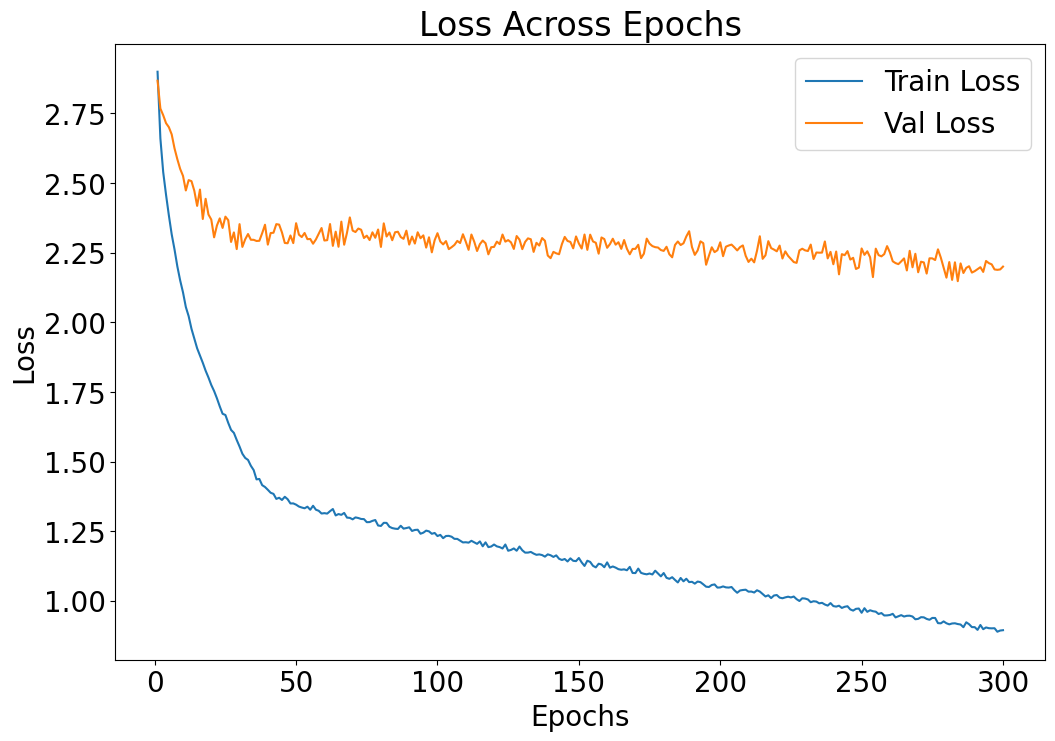

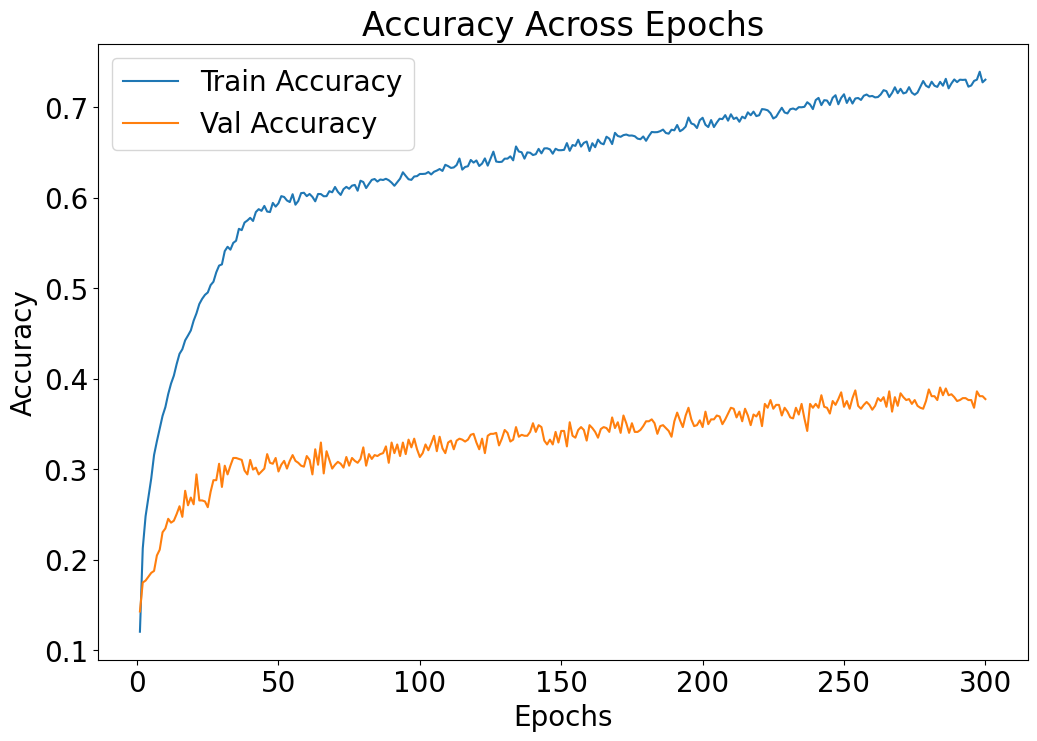

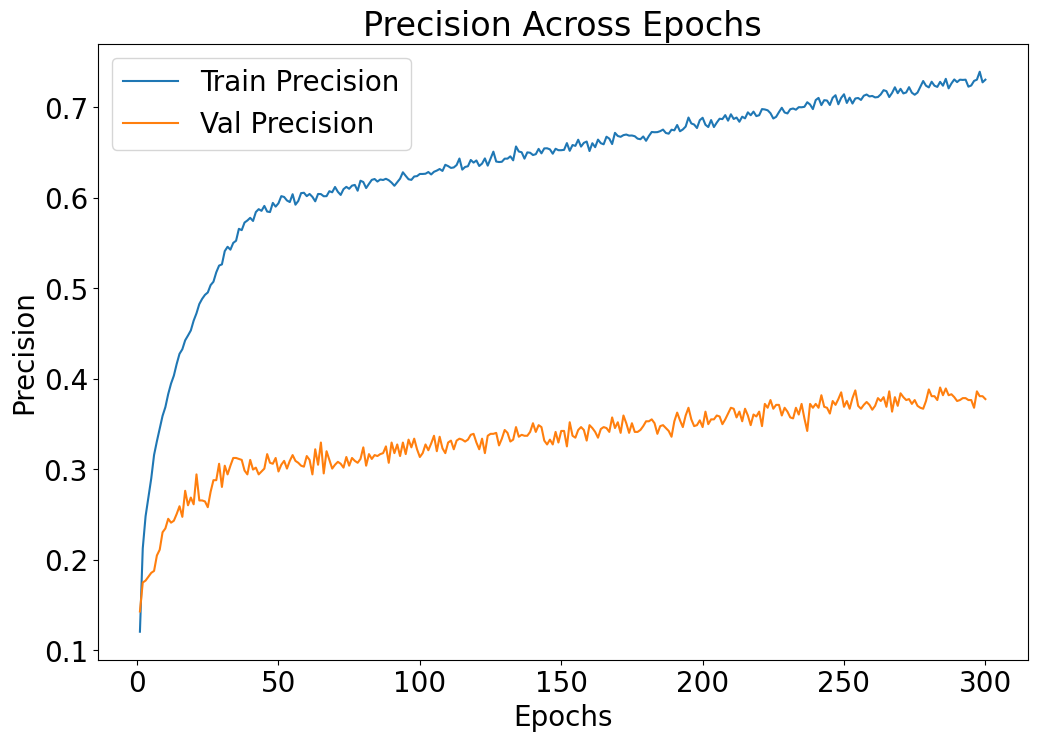

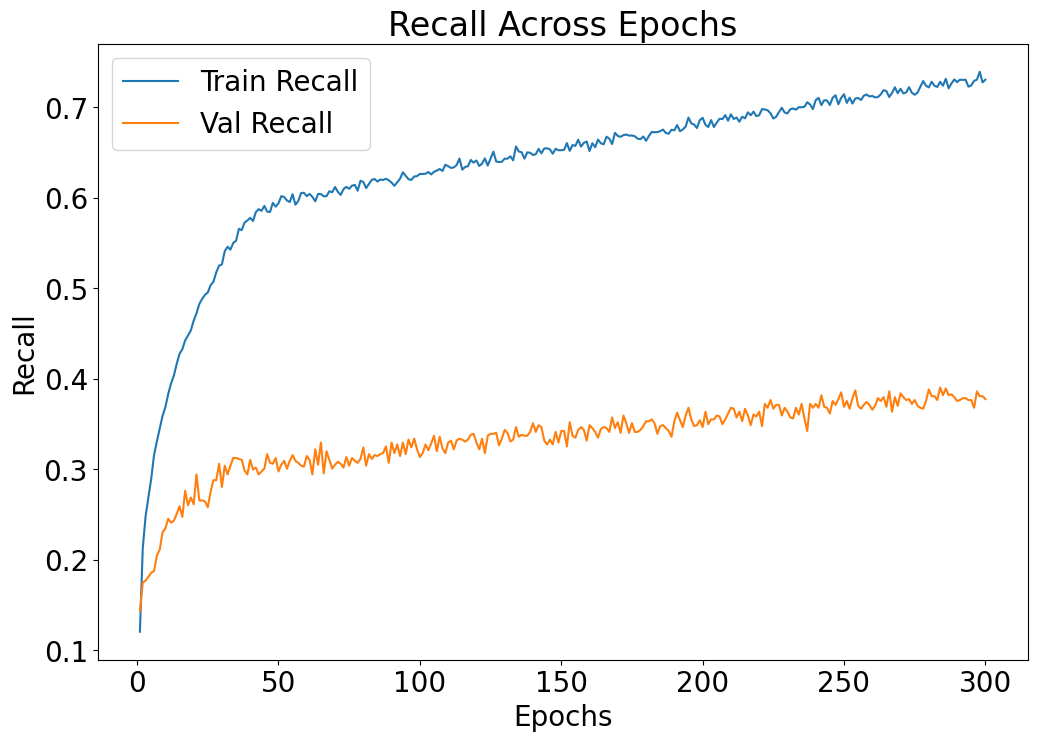

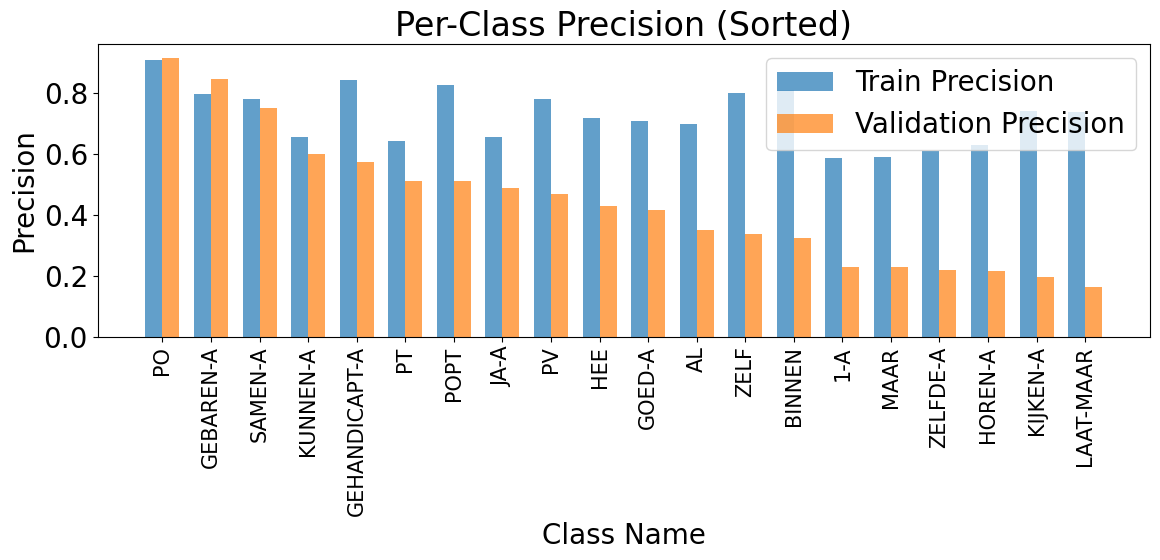

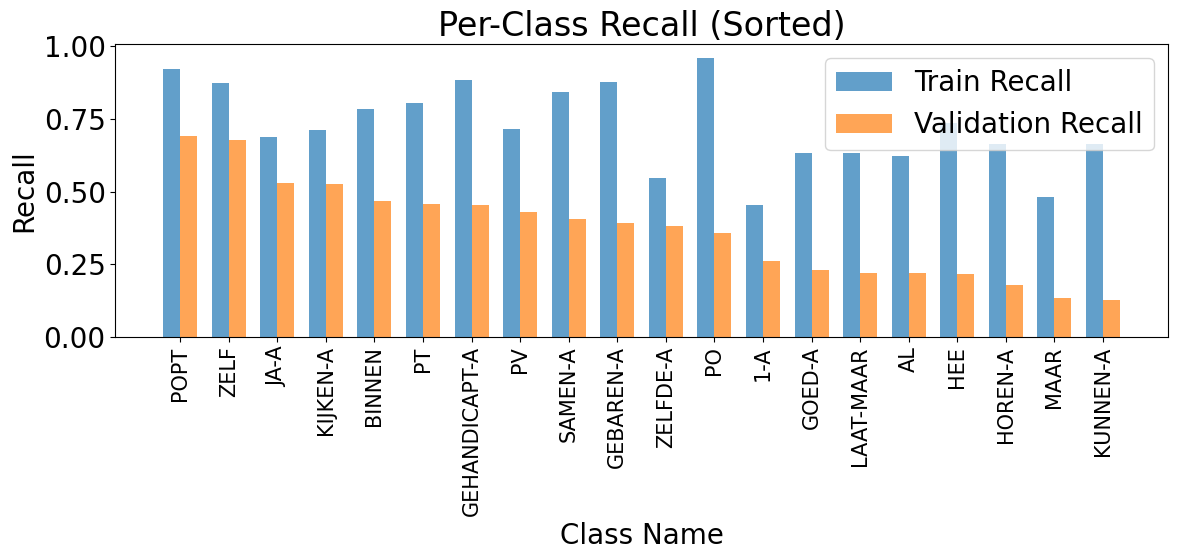

In [21]:
# Plotting results
epochs = range(1, num_epochs + 1)

# Loss plot
plt.rcParams['font.size'] = 20
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = 20
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Across Epochs')
plt.savefig(modelweights+'/Train-Val Loss.png')
plt.show()

# Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Across Epochs')
plt.savefig(modelweights+'/Train-Val Accuracy.png')
plt.show()

# Precision plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Precision.png')
plt.show()

# Recall plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Recall.png')
plt.show()

# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_precision)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.title('Per-Class Precision (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Precision Per Class.png')
plt.show()

# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_recall)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.title('Per-Class Recall (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Recall Per Class.png')
plt.show()

In [22]:
#Save metrics for later
import pickle

# Combine metrics into a dictionary
metrics = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
    "train_precision": train_precision,
    "val_precision": val_precision,
    "train_precision_per_class": train_precision_per_class,
    "val_precision_per_class": val_precision_per_class,
    "train_recall": train_recall,
    "val_recall": val_recall,
    "train_recall_per_class": train_recall_per_class,
    "val_recall_per_class": val_recall_per_class
}

# Save to a pickle file
with open(modelweights + "/" + "metrics.pkl", "wb") as f:
   pickle.dump(metrics, f)

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

In [23]:
print(max(val_acc))
print(val_acc[-1])

0.39019189765458423
0.3773987206823028


In [24]:
print(max(train_acc))
print(train_acc[-1])

0.7389162561576355
0.7301291439222474


### 6 Test Model

In [25]:
import torch
from tqdm import tqdm
import numpy as np

def test_model(model, test_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Compute predictions
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    test_accuracy_per_class = correct_per_class / total_per_class
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean(test_accuracy_per_class)  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class


In [26]:
epoch = "295"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class = test_model(
    model, test_dl, device, num_classes)

Testing: 100%|██████████| 30/30 [00:52<00:00,  1.73s/it]

Test Summary:
Test Loss: 2.4748, Accuracy: 0.3173, Precision: 0.2624, Recall: 0.2532
Per-Class Precision: [0.19861111 0.08333333 0.16666667 0.36666667 0.46666667 0.28888889
 0.32777778 0.26111111 0.26920635 0.33944445 0.         0.28277778
 0.15       0.4        0.44761905 0.45333334 0.22777778 0.46111111
 0.04555556 0.01111111]
Per-Class Recall: [0.26388889 0.02777778 0.20833334 0.22777778 0.42277778 0.17055556
 0.26111111 0.28611111 0.23388889 0.46222222 0.         0.24388889
 0.12222222 0.31388889 0.54111111 0.51944445 0.27222222 0.35833333
 0.11666667 0.01111111]
Per-Class Accuracy: [0.30952381 0.07142857 0.39393939 0.29166667 0.54347826 0.18644068
 0.32653061 0.28       0.34042553 0.55555556 0.         0.32075472
 0.15555556 0.375      0.75471698 0.50909091 0.37142857 0.38
 0.09302326 0.02222222]


In [30]:
test_metrics = {
    "test_loss" : test_loss,
    "test_acc" : test_acc,
    "test_precision" : test_precision,
    "test_precision_per_class" : test_precision_per_class,
    "average_test_precision_per_class" : average_test_precision_per_class,
    "test_recall" : test_recall,
    "test_recall_per_class" : test_recall_per_class,
    "average_test_recall_per_class" : average_test_recall_per_class,
    "test_accuracy_per_class" : test_accuracy_per_class,
    "average_test_accuracy_per_class" : average_test_accuracy_per_class
}

# Save to a pickle file
with open(modelweights + "/" + "test_metrics" + epoch + ".pkl", "wb") as f:
    pickle.dump(test_metrics, f)


# Save to a pickle file
with open(modelweights + "/" + "test_metrics" + epoch + ".pkl", "rb") as f:
    test_loaded_metrics = pickle.load(f)

# Verify the loaded data
print("Loaded Metrics:", test_loaded_metrics)

Loaded Metrics: {'test_loss': 2.4748383301955004, 'test_acc': 0.3173076923076923, 'test_precision': np.float64(0.2623829375952482), 'test_precision_per_class': array([0.19861111, 0.08333333, 0.16666667, 0.36666667, 0.46666667,
       0.28888889, 0.32777778, 0.26111111, 0.26920635, 0.33944445,
       0.        , 0.28277778, 0.15      , 0.4       , 0.44761905,
       0.45333334, 0.22777778, 0.46111111, 0.04555556, 0.01111111]), 'average_test_precision_per_class': np.float64(0.2623829375952482), 'test_recall': np.float64(0.25316666767001156), 'test_recall_per_class': array([0.26388889, 0.02777778, 0.20833334, 0.22777778, 0.42277778,
       0.17055556, 0.26111111, 0.28611111, 0.23388889, 0.46222222,
       0.        , 0.24388889, 0.12222222, 0.31388889, 0.54111111,
       0.51944445, 0.27222222, 0.35833333, 0.11666667, 0.01111111]), 'average_test_recall_per_class': np.float64(0.2531666676700115), 'test_accuracy_per_class': array([0.30952381, 0.07142857, 0.39393939, 0.29166667, 0.54347826,


### 7 Test Model Random Selector


In [33]:
import torch
from tqdm import tqdm
import numpy as np

def test_random_baseline(test_loader, device, num_classes):
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing Random Baseline"):
            labels = labels.to(device)

            # Generate random predictions
            batch_size = labels.size(0)
            random_preds = torch.randint(0, num_classes, (batch_size,), device=device)

            # Compute loss (random predictions vs. actual labels)
            loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits

            # Update running loss
            running_loss += loss.item() * batch_size

            # Compute accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += batch_size

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((random_preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    test_accuracy_per_class = correct_per_class / total_per_class
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean(test_accuracy_per_class)  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class


In [34]:
# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, \
random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test_random_baseline(
    test_dl, device, num_classes
)

Testing Random Baseline: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]

Test Summary:
Test Loss: 3.4366, Accuracy: 0.0598, Precision: 0.0527, Recall: 0.0460
Per-Class Precision: [0.03611111 0.01111111 0.09444444 0.11666667 0.         0.10833333
 0.04444444 0.03333333 0.10555556 0.07777778 0.03333333 0.04
 0.09444444 0.07777778 0.04444444 0.03611111 0.01111111 0.05
 0.01666667 0.02222222]
Per-Class Recall: [0.03055556 0.01111111 0.11111111 0.04722222 0.         0.08055556
 0.03611111 0.03333333 0.065      0.04833333 0.00833333 0.08333333
 0.05555556 0.08333333 0.02333333 0.03611111 0.01666667 0.08333333
 0.03333333 0.03333333]
Per-Class Accuracy: [0.07142857 0.02380952 0.15151515 0.08333333 0.         0.10169492
 0.06122449 0.04       0.10638298 0.06666667 0.02083333 0.05660377
 0.08888889 0.0625     0.03773585 0.05454545 0.02857143 0.08
 0.02325581 0.04444444]


In [38]:
random_test_metrics = {
    "test_loss" : random_test_loss,
    "test_acc" : random_test_acc,
    "test_precision" : random_test_precision,
    "test_precision_per_class" : random_test_precision_per_class,
    "average_test_precision_per_class" : random_average_test_precision_per_class,
    "test_recall" : random_test_recall,
    "test_recall_per_class" : random_test_recall_per_class,
    "average_test_recall_per_class" : random_average_test_recall_per_class
}

# Save to a pickle file
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "wb") as f:
    pickle.dump(random_test_metrics, f)

# Save to a pickle file
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "rb") as f:
    random_test_loaded_metrics = pickle.load(f)

# Verify the loaded data
print("Loaded Metrics:", random_test_loaded_metrics)

Loaded Metrics: {'test_loss': 3.436554171081282, 'test_acc': 0.05982905982905983, 'test_precision': np.float64(0.052694444755713145), 'test_precision_per_class': array([0.03611111, 0.01111111, 0.09444444, 0.11666667, 0.        ,
       0.10833333, 0.04444444, 0.03333333, 0.10555556, 0.07777778,
       0.03333333, 0.04      , 0.09444444, 0.07777778, 0.04444444,
       0.03611111, 0.01111111, 0.05      , 0.01666667, 0.02222222]), 'average_test_precision_per_class': np.float64(0.05269444475571315), 'test_recall': np.float64(0.04600000021358331), 'test_recall_per_class': array([0.03055556, 0.01111111, 0.11111111, 0.04722222, 0.        ,
       0.08055556, 0.03611111, 0.03333333, 0.065     , 0.04833333,
       0.00833333, 0.08333333, 0.05555556, 0.08333333, 0.02333333,
       0.03611111, 0.01666667, 0.08333333, 0.03333333, 0.03333333]), 'average_test_recall_per_class': np.float64(0.04600000021358332)}


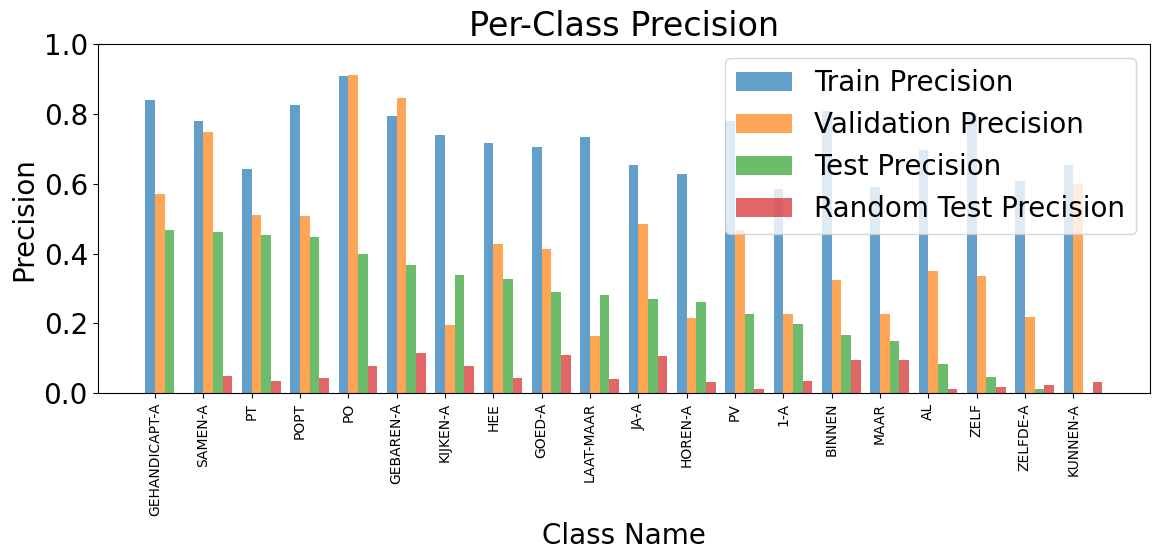

In [39]:
# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]
last_test_precision = test_precision_per_class
last_random_test_precision = random_test_precision_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_precision_per_class)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
sorted_test_precision = np.array(last_test_precision)[sorted_indices]
sorted_random_test_precision = np.array(last_random_test_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_precision, bar_width, label='Test Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_precision, bar_width, label='Random Test Precision', alpha=0.7)
plt.title('Per-Class Precision')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=10)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Precision Per Class'+epoch+'.png')
plt.show()

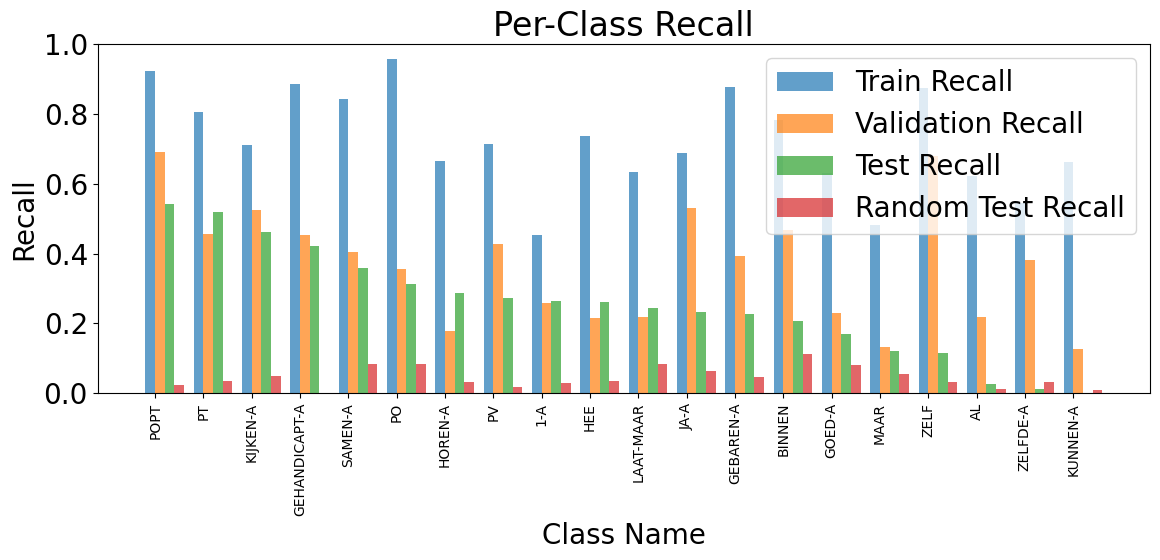

In [40]:
# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]
last_test_recall = test_recall_per_class
last_random_test_recall = random_test_recall_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_recall_per_class)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
sorted_test_recall = np.array(last_test_recall)[sorted_indices]
sorted_random_test_recall = np.array(last_random_test_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_recall, bar_width, label='Test Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_recall, bar_width, label='Random Test Recall', alpha=0.7)
plt.title('Per-Class Recall')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=10)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Recall Per Class'+epoch+'.png')
plt.show()

### Qualitative Analysis

In [41]:
labels_dict_keys = list(labels_dict.keys())
labels_dict_keys[2]

'BINNEN'

In [65]:
import os

def save_file_paths(sample_info_dict, filename):
    """
    Save sample info (true_label, pred_label, frame_paths) to a text file.
    """
    with open(filename, "w") as file:
        for sample_id, (true_label, pred_label, file_paths) in sample_info_dict.items():
            file.write(f"{true_label},{pred_label}," + ",".join(file_paths) + "\n")


def sample_inspection(model, test_loader, device, num_classes, labels_dict_keys, sample_size=10, num_frames=8):
    model.eval()
    correct_samples = {}
    misclassified_samples = {}
    sample_info = {}  # To store (true_label, predicted_label, file_path) for each sample

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):  
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Access the file paths directly from the batch, since the `file_paths` are precomputed
            file_paths_batch = test_loader.dataset.file_paths[batch_idx * test_loader.batch_size: (batch_idx + 1) * test_loader.batch_size]

            for i in range(len(labels)):
                sample_id = batch_idx * test_loader.batch_size + i  # Unique sample index
                true_label = labels[i].item()
                pred_label = preds[i].item()

                # Get the file path for the sample in the batch
                file_path = file_paths_batch[i]

                if pred_label == true_label:  # Correct prediction
                    if sample_id not in misclassified_samples:
                        correct_samples[sample_id] = inputs[i].cpu()
                        sample_info[sample_id] = (true_label, pred_label, file_path)
                else:  # Incorrect prediction
                    misclassified_samples[sample_id] = inputs[i].cpu()
                    sample_info[sample_id] = (true_label, pred_label, file_path)
                    correct_samples.pop(sample_id, None)  # Remove if it was previously correct

    # Select `sample_size` correct and misclassified samples
    correct_keys = list(correct_samples.keys())[:sample_size]
    misclassified_keys = list(misclassified_samples.keys())[:sample_size]

    print(f"Selected {len(correct_keys)} correct and {len(misclassified_keys)} misclassified samples.")

    # Save the file paths of the correct and misclassified samples to text files
    save_file_paths({k: sample_info[k] for k in correct_keys}, "correct_samples_resnet.txt")
    save_file_paths({k: sample_info[k] for k in misclassified_keys}, "misclassified_samples_resnet.txt")

    # Plot function
    def plot_samples(sample_dict, title):
        fig, axes = plt.subplots(sample_size, num_frames, figsize=(num_frames * 2, sample_size * 2))
        fig.suptitle(title, fontsize=16, y=0.92)

        for row, key in enumerate(sample_dict.keys()):
            sample = sample_dict[key]  # Tensor with shape (C, T, H, W)
            true_label, pred_label, file_path = sample_info[key]  # Retrieve labels and file path

            C, T, H, W = sample.shape  # Extract dimensions
            num_selected_frames = min(num_frames, T)

            for col in range(num_selected_frames):
                frame = sample[:, col, :, :]  # Extract the `col`-th frame from the time dimension

                if C == 1:  # Grayscale case (C=1, T, H, W)
                    img = frame.squeeze(0).numpy()  # Convert (1, H, W) → (H, W)
                    cmap = "gray"
                elif C == 3:  # RGB case (C=3, T, H, W)
                    img = frame.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
                    cmap = None
                else:
                    raise ValueError(f"Unexpected number of channels: {C}")

                # Normalize image for visualization
                img = (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img

                axes[row, col].imshow(img, cmap=cmap)
                axes[row, col].axis("off")

            # Add text annotation above the first frame of each row
            true_label_name = labels_dict_keys[true_label]  # Convert true label index to name
            pred_label_name = labels_dict_keys[pred_label]  # Convert predicted label index to name
            path = file_path[0].split("frame0")[0]
            axes[row, 0].set_title(f"GT: {true_label_name} | Pred: {pred_label_name} | Path: {path}", fontsize=10, ha="left")

        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.show()

    # Plot samples
    if correct_keys:
        plot_samples({k: correct_samples[k] for k in correct_keys}, "Correct Samples")

    if misclassified_keys:
        plot_samples({k: misclassified_samples[k] for k in misclassified_keys}, "Misclassified Samples")

    return correct_keys, misclassified_keys


In [ ]:
# Run after testing your model
correct_samples, misclassified_samples = sample_inspection(model, test_dl, device, num_classes, labels_dict_keys, sample_size=936)


In [90]:
import torch
from tqdm import tqdm
import numpy as np

def test(test_loader, device, num_classes, random_baseline=False):

    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing" if not random_baseline else "Testing Random Baseline"):
            inputs, labels = inputs.to(device), labels.to(device)

            if random_baseline:
                # Generate random predictions for random baseline
                batch_size = labels.size(0)
                random_preds = torch.randint(0, num_classes, (batch_size,), device=device)
                loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits
            else:
                # Use the model to make predictions
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                random_preds = torch.argmax(outputs, dim=1)  # Predicted labels using the model

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((random_preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    
    # Calculate per-class accuracy as a dictionary
    test_accuracy_per_class_dict = {i: correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0 
                                    for i in range(num_classes)}
    
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean([test_accuracy_per_class_dict[i] for i in range(num_classes)])  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class_dict}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class_dict, average_test_accuracy_per_class

epoch = "295"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class = test(test_dl, device, num_classes, random_baseline=False)

# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, \
random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test(test_dl, device, num_classes, random_baseline=True)


Testing: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


Test Summary:
Test Loss: 2.4748, Accuracy: 0.3173, Precision: 0.2624, Recall: 0.2532
Per-Class Precision: [0.19861111 0.08333333 0.16666667 0.36666667 0.46666667 0.28888889
 0.32777778 0.26111111 0.26920635 0.33944445 0.         0.28277778
 0.15       0.4        0.44761905 0.45333334 0.22777778 0.46111111
 0.04555556 0.01111111]
Per-Class Recall: [0.26388889 0.02777778 0.20833334 0.22777778 0.42277778 0.17055556
 0.26111111 0.28611111 0.23388889 0.46222222 0.         0.24388889
 0.12222222 0.31388889 0.54111111 0.51944445 0.27222222 0.35833333
 0.11666667 0.01111111]
Per-Class Accuracy: {0: np.float64(0.30952380952380953), 1: np.float64(0.07142857142857142), 2: np.float64(0.3939393939393939), 3: np.float64(0.2916666666666667), 4: np.float64(0.5434782608695652), 5: np.float64(0.1864406779661017), 6: np.float64(0.32653061224489793), 7: np.float64(0.28), 8: np.float64(0.3404255319148936), 9: np.float64(0.5555555555555556), 10: np.float64(0.0), 11: np.float64(0.32075471698113206), 12: np.f

Testing Random Baseline: 100%|██████████| 30/30 [00:15<00:00,  2.00it/s]

Test Summary:
Test Loss: 3.5143, Accuracy: 0.0534, Precision: 0.0397, Recall: 0.0410
Per-Class Precision: [0.065      0.01666667 0.         0.01111111 0.03333333 0.03333333
 0.06944444 0.03055556 0.05833333 0.03611111 0.06777778 0.03333333
 0.01666667 0.06666667 0.08888889 0.04444445 0.01111111 0.06666667
 0.01666667 0.02777778]
Per-Class Recall: [0.06777778 0.01666667 0.         0.01111111 0.04166667 0.00666667
 0.04722222 0.03611111 0.09444444 0.03166667 0.07222222 0.01666667
 0.03333333 0.1        0.04166667 0.05833333 0.03333333 0.05
 0.01666667 0.04444444]
Per-Class Accuracy: {0: np.float64(0.09523809523809523), 1: np.float64(0.023809523809523808), 2: np.float64(0.0), 3: np.float64(0.020833333333333332), 4: np.float64(0.06521739130434782), 5: np.float64(0.01694915254237288), 6: np.float64(0.08163265306122448), 7: np.float64(0.06), 8: np.float64(0.10638297872340426), 9: np.float64(0.06666666666666667), 10: np.float64(0.08333333333333333), 11: np.float64(0.018867924528301886), 12: n

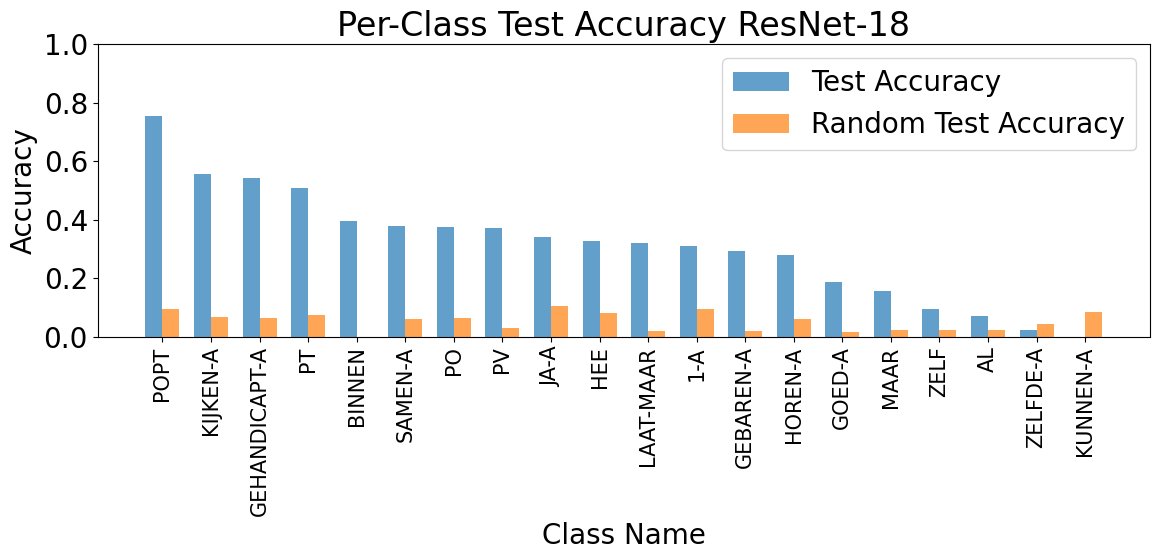

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming last_test_accuracy is a dictionary with class index as keys and accuracy as values
last_test_accuracy = test_accuracy_per_class  # This is now a dict
random_last_test_accuracy = random_test_accuracy_per_class  # This is also a dict

bar_width = 0.35
indices = np.arange(len(last_test_accuracy))  # Length of the dictionary

# Sort the dictionary based on accuracy (values) in descending order
sorted_accuracy = {k: v for k, v in sorted(last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}
sorted_random_accuracy = {k: v for k, v in sorted(random_last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}

# Extract sorted indices and accuracies
sorted_indices = list(sorted_accuracy.keys())  # Sorted class indices based on accuracy
sorted_test_accuracy = list(sorted_accuracy.values())  # Sorted test accuracies
sorted_random_test_accuracy = [sorted_random_accuracy[i] for i in sorted_indices]  # Align random accuracy with sorted indices

# Reverse the dictionary to map indices to labels
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

# Plotting the data
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_test_accuracy, bar_width, label='Test Accuracy', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_random_test_accuracy, bar_width, label='Random Test Accuracy', alpha=0.7)
plt.title('Per-Class Test Accuracy ResNet-18')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Update x-axis labels with class names if labels_dict is available
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)

plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Test Accuracy Per Class'+epoch+'.png')
plt.show()



In [104]:
def compare_samples(model1_file_paths, model2_file_paths):
    """
    Compare the file paths between two models and return the common paths and the unique paths.
    """
    model1_set = set(model1_file_paths)  # Convert to set for easier comparison
    model2_set = set(model2_file_paths)

    common_paths = model1_set.intersection(model2_set)
    model1_only = model1_set - model2_set
    model2_only = model2_set - model1_set

    return common_paths, model1_only, model2_only

# Load the file paths from the saved text files
with open("correct_samples_resnet.txt", "r") as f:
    model1_correct_paths = [line.strip() for line in f.readlines()]

with open("misclassified_samples_resnet.txt", "r") as f:
    model1_misclassified_paths = [line.strip() for line in f.readlines()]

# Now compare with the file paths from the second model
with open("correct_samples_VideoMAE.txt", "r") as f:
    model2_correct_paths = [line.strip() for line in f.readlines()]

with open("misclassified_samples_VideoMAE.txt", "r") as f:
    model2_misclassified_paths = [line.strip() for line in f.readlines()]

# Compare the samples
common_correct, model1_only_correct, model2_only_correct = compare_samples(model1_correct_paths, model2_correct_paths)
common_misclassified, model1_only_misclassified, model2_only_misclassified = compare_samples(model1_misclassified_paths, model2_misclassified_paths)

print(f"Common Correct Samples: {len(common_correct)}")
print(f"ResNet-18 Only Correct: {len(model1_only_correct)}")
print(f"VideoMAE LSTM Only Correct: {len(model2_only_correct)}")

print(f"Common Misclassified Samples: {len(common_misclassified)}")
print(f"ResNet-18 Only Misclassified: {len(model1_only_misclassified)}")
print(f"VideoMAE LSTM Only Misclassified: {len(model2_only_misclassified)}")

Common Correct Samples: 185
ResNet-18 Only Correct: 112
VideoMAE LSTM Only Correct: 211
Common Misclassified Samples: 85
ResNet-18 Only Misclassified: 554
VideoMAE LSTM Only Misclassified: 455


In [105]:
def load_sequences(file_path, num_frames=8):
    """Load sequences along with true and predicted labels from a file."""
    sequences = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            true_label = int(parts[0])  # Extract true label
            pred_label = int(parts[1])  # Extract predicted label
            frame_paths = parts[2:]  # Extract frame paths
            sequences.append((true_label, pred_label, frame_paths))
    return sequences


In [110]:
# Load sequences with labels
model1_correct_sequences = load_sequences("correct_samples_resnet.txt")
model1_misclassified_sequences = load_sequences("misclassified_samples_resnet.txt")
model2_correct_sequences = load_sequences("correct_samples_VideoMAE.txt")
model2_misclassified_sequences = load_sequences("misclassified_samples_VideoMAE.txt")

# Convert to sets for easy comparison
model1_correct_set = set((true_label, pred_label, tuple(frame_paths)) for true_label, pred_label, frame_paths in model1_correct_sequences)
model1_misclassified_set = set((true_label, pred_label, tuple(frame_paths)) for true_label, pred_label, frame_paths in model1_misclassified_sequences)
model2_correct_set = set((true_label, pred_label, tuple(frame_paths)) for true_label, pred_label, frame_paths in model2_correct_sequences)
model2_misclassified_set = set((true_label, pred_label, tuple(frame_paths)) for true_label, pred_label, frame_paths in model2_misclassified_sequences)

# Categorize sequences
model1_correct_model2_wrong = model1_correct_set & model2_misclassified_set
model1_wrong_model2_correct = model1_misclassified_set & model2_correct_set
both_wrong = model1_misclassified_set & model2_misclassified_set
both_correct = model1_correct_set & model2_correct_set


In [111]:
import matplotlib.pyplot as plt
import cv2

def plot_sequence(true_label, pred_label, frame_paths, title, labels_dict_keys):
    """Plot a single sequence of 8 frames with labels."""
    fig, axes = plt.subplots(1, len(frame_paths), figsize=(16, 4))
    gt_label = labels_dict_keys[true_label]
    pred_label = labels_dict_keys[pred_label]
    fig.suptitle(f"{title}\nGT: {gt_label} | Pred: {pred_label}", fontsize=16, y=0.78)

    for i, frame_path in enumerate(frame_paths):
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

        axes[i].imshow(img)
        axes[i].axis("off")

    plt.show()

def plot_samples(samples, title, labels_dict_keys, sample_size=3):
    """Plot a few sequences from the given category."""
    samples = list(samples)[:sample_size]  # Select first `sample_size` samples
    for true_label, pred_label, frame_paths in samples:
        plot_sequence(true_label, pred_label, frame_paths, title, labels_dict_keys)



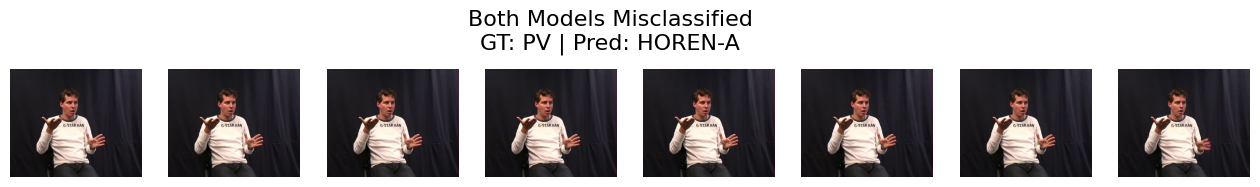

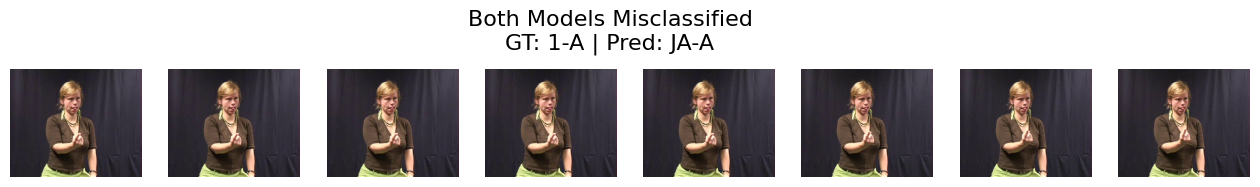

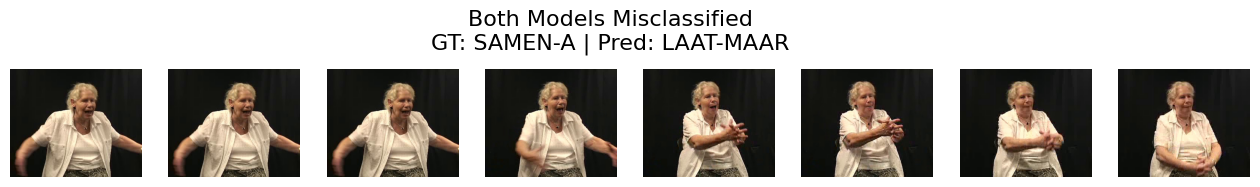

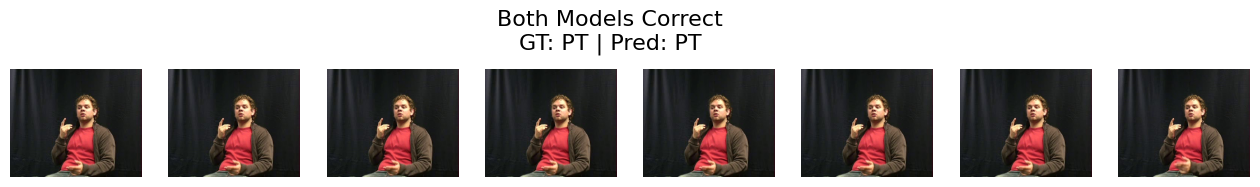

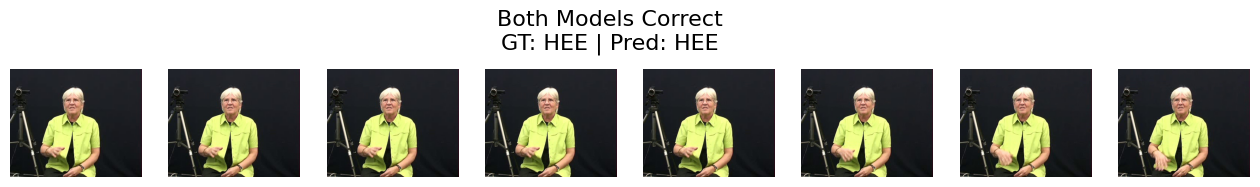

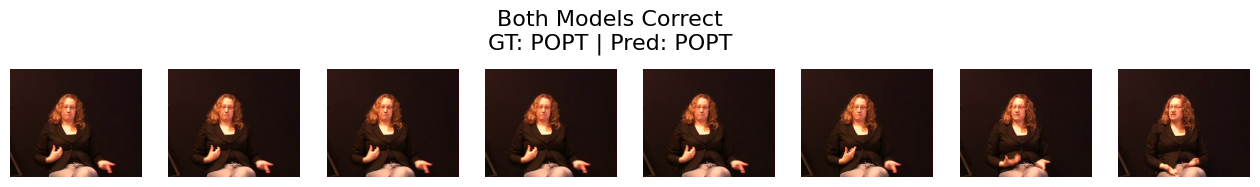

In [112]:
# Display some samples from each category
plot_samples(model1_correct_model2_wrong, "ResNet-18 Correct, VideoMAE Wrong", labels_dict_keys)
plot_samples(model1_wrong_model2_correct, "ResNet-18 Wrong, Model 2 Correct", labels_dict_keys)
plot_samples(both_wrong, "Both Models Misclassified", labels_dict_keys)
plot_samples(both_correct, "Both Models Correct", labels_dict_keys)
